#### 환경 설정

1. 필요한 라이브러리 다운

In [ ]:
! pip install ultralytics
! pip incstall opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
### 모델 관련 ----
import ultralytics
from ultralytics import YOLO
# 제대로 설치되었는지 확인하는 코드
ultralytics.checks()
### 경로 설정 시 ----
import os
### 바운딩박스 생성 시 ----
from PIL import Image
### 데이터 분리할 때 사용 ----
import random
import shutil
### yaml 파일 생성 ----
import yaml
#### 그림 그리고, 레이블링 할 때 ----
import cv2
import matplotlib.pyplot as plt
### 혹시 모르니까 설치하는 부분 ----
import pandas as pd
import numpy as np

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.3/112.6 GB disk)


2. 경로 설정

In [ ]:
### 데이터 ---- *나중에 없으면 만들도록 할 수 있음! 일단 정해만 두기
# 현재 데이터 있는 곳
base_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP" # 일단 AP로
# 데이터 분리해서 담아둘 곳 (train, val / image, label 분리)
to_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_AP/DATA_AP/"

### YAML 파일 담을 곳 ----
yaml_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_AP/YAML_AP/"

### 결과 파일 담을 곳 ----
results_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_AP/Results"

#### 데이터 준비

1. 바운딩박스 만들기

In [ ]:
# 전체 파일 읽어오기
files_list = [file for file in os.listdir(base_path) if file.endswith(".csv")]

# 전체 파일 이름 읽어오기
file_names = [os.path.splitext(file)[0] for file in os.listdir(base_path) if file.endswith(".csv")]
file_names[:5]

['0107-F-033Y0',
 '0024-F-014Y0',
 '0031-F-014Y0',
 '0101-F-022Y0',
 '0102-F-013Y0']

In [ ]:
# 한 장 가지고 진행한다고 생각 - 두 줄로 바운딩박스 만드는 함수
def create_bbox_2lines(line1, line2, width, height):
    # x, y 좌표 읽기
    x_coords = [line1[0], line1[2], line2[0], line2[2]]
    y_coords = [line1[1], line1[3], line2[1], line2[3]]

    # 최대, 최소
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # 중심, 크기
    x_center = (x_min + x_max) / 2 / width
    y_center = (y_min + y_max) / 2 / height
    bb_width = (x_max - x_min) / width
    bb_height = (y_max - y_min) / height

    # 라벨
    # class_id = max(int(line1[4]), int(line2[4]))
    class_id = 0

    return [class_id, x_center, y_center, bb_width, bb_height]

# 한 장 전체
def create_bbox_pic(file_name, width, height):
    bb_csv_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/{file_name}.csv"
    lines = pd.read_csv(bb_csv_path, header = None)
    yolo_boxes = []
    for i in range(0, len(lines)-1, 2):
        yolo_box = create_bbox_2lines(
            lines.iloc[i].tolist(),
            lines.iloc[i+1].tolist(),
            width, height)
        yolo_boxes.append(yolo_box)

    # 저장하기
    txt_path = bb_csv_path.replace(".csv", ".txt")
    with open(txt_path, "w") as f:
        for box in yolo_boxes:
            f.write(' '.join(map(str, box)) + '\n')

# 여러 장으로 확장
def make_bbox(file_names):
    for file_name in file_names: # 이름 하나 받아서

        # Width, Height 출력
        bb_image_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/{file_name}.jpg"
        image = Image.open(bb_image_path)
        width, height = image.size
        # print(f"Width : {width}, Height : {height}")

        # 한 장 전체에서 bounding box
        create_bbox_pic(file_name, width, height)

In [ ]:
make_bbox(file_names)

2. 데이터 분리 (train,val / image, label)

In [ ]:
### 폴더 생성
# 이미지/ 라벨 분리
img_ = '.jpg'
label_ = '.txt'

# 저장 경로 만들기
folders_list = [os.path.join(to_path, 'train'),
                os.path.join(to_path, 'val'),
                os.path.join(to_path, 'train/images'),
                os.path.join(to_path, 'val/images'),
                os.path.join(to_path, 'train/labels'),
                os.path.join(to_path, 'val/labels')]

# 없으면 생성해주세용
for folder in folders_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [ ]:
### 데이터 분리
# 1. 데이터 섞고
random.shuffle(files_list)

# 2. Train/Test 분리
ratio = 0.8
train_list = files_list[: int(len(files_list) * ratio)]
test_list = files_list[int(len(files_list) * ratio) :]

# 3. File 이동
for i in train_list: # train
    file_name = os.path.splitext(i)[0] # 파일 이름
    shutil.copyfile(os.path.join(base_path, (file_name + img_)), os.path.join(to_path, 'train/images', (file_name + img_)))
    shutil.copyfile(os.path.join(base_path, (file_name + label_)), os.path.join(to_path, 'train/labels', (file_name + label_)))

for i in test_list: # test
    file_name = os.path.splitext(i)[0] # 파일 이름
    shutil.copyfile(os.path.join(base_path, (file_name + img_)), os.path.join(to_path, 'val/images', (file_name + img_)))
    shutil.copyfile(os.path.join(base_path, (file_name + label_)), os.path.join(to_path, 'val/labels', (file_name + label_)))

3. YAML 파일 만들기

In [ ]:
classes = []
for name in file_names:
    check_txt_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/AP/{name}.txt"
    txt_file = pd.read_csv(check_txt_path, delimiter = ' ', header = None)
    classs = txt_file.iloc[:, 0] # 첫 열만 가져오기
    classes.extend(classs.tolist())

uniq_classes = pd.Series(classes)
uniq_classes.value_counts()

,count
0,2000


In [ ]:
# 폴더 없으면 만들기
if not os.path.exists(yaml_path):
    os.makedirs(yaml_path)

# 그 폴더로 들어가기
os.chdir(yaml_path)

# YAML 파일
data = dict()

#
data['train'] = os.path.join(to_path, 'train')
data['val'] = os.path.join(to_path, 'val')
data['test'] = os.path.join(to_path, 'val')

# 클래스 수
data['class'] = 1
data['names'] = ['Yochoo']

# YAML 파일로 저장
with open('spine_ap.yaml', 'w') as f:
    yaml.dump(data, f)

#### Train

In [ ]:
from ultralytics import YOLO
# 모델 불러오기
model = YOLO('yolov8s.yaml')
# 학습 코드
results = model.train(data = 'spine_ap.yaml',
                      epochs = 20,
                      batch = 16, # 일반적으로 32
                      imgsz = (640, 400), # 입력 이미지 크기 고정 (세로로 긴 직사각형)
                      # - 사전에 안 고치고 진행할거면 이렇게 하면 됨 (근데 데이터 왜곡이 조금 있을 수도 있대)
                      device = 0, # 0이 GPU
                      patience = 3, # 성능 향상이 없는 경우 기다릴 epoch
                      name = 'trained_ap', # 저장할 이름
                      project = results_path)

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=spine_ap.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(640, 400), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=trained_ap, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=3, perspective=0.0, plots=True, pose=12.0, pretrained=True,

train: Scanning /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models/Model_AP/DATA_AP/train/labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.0±0.9 ms, read: 164.9±85.7 MB/s, size: 1502.5 KB)


val: Scanning /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models/Model_AP/DATA_AP/val/labels.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models/Model_AP/Results/trained_ap/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models/Model_AP/Results/trained_ap
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.17G      4.983      3.858      4.078        108        640: 100%|██████████| 20/20 [00:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         80        400          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.92G      3.595       2.97      3.778        138        640: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         80        400          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.92G      2.875      2.515      3.142        134        640: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         80        400     0.0126      0.757     0.0124    0.00353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.92G      2.687      2.315      2.724        152        640: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         80        400     0.0146      0.877     0.0191    0.00657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.92G      2.561      2.179      2.448        149        640: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         80        400     0.0284      0.472     0.0232    0.00675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.92G      2.473      1.989      2.261        163        640: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         80        400      0.052     0.0975      0.035     0.0152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.92G      2.218      1.848      2.068        174        640: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         80        400      0.224      0.403      0.219      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.92G      2.175      1.729      2.014        124        640: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         80        400      0.428      0.552      0.473      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.92G      2.042       1.59      1.884        157        640: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         80        400      0.487       0.61      0.559      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.92G      1.989      1.507      1.856        141        640: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         80        400      0.686       0.68       0.74      0.423


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.92G      1.825      1.515       1.86         79        640: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         80        400       0.73      0.745      0.794      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.92G      1.673      1.289      1.766         79        640: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         80        400      0.824      0.823      0.867      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.92G      1.574      1.215      1.712         80        640: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         80        400      0.862      0.797      0.882      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.93G      1.513      1.123      1.661         79        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         80        400      0.852      0.855      0.915      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.93G      1.422      1.036      1.585         80        640: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         80        400      0.844      0.896       0.93      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.93G      1.389      0.973      1.542         80        640: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         80        400      0.881      0.921      0.949        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.93G      1.368     0.9331      1.514         80        640: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         80        400      0.863      0.916       0.95      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.96G      1.344     0.9003      1.511         79        640: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         80        400      0.883      0.925      0.957      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.96G      1.327       0.87      1.479         80        640: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         80        400      0.931      0.887      0.965      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.96G      1.274     0.8473      1.438         80        640: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         80        400      0.907      0.925      0.963      0.649



20 epochs completed in 0.117 hours.
Optimizer stripped from /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models/Model_AP/Results/trained_ap/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models/Model_AP/Results/trained_ap/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models/Model_AP/Results/trained_ap/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


                   all         80        400      0.907      0.924      0.963      0.648
Speed: 0.2ms preprocess, 6.0ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models/Model_AP/Results/trained_ap



0: 640x416 5 Yochoos, 12.5ms
Speed: 3.2ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)
5개의 박스가 만들어졌어용..


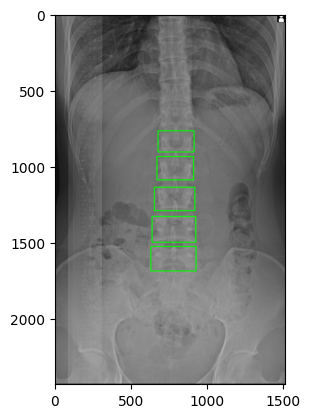

In [ ]:
### Inference
model_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_AP/Results/trained_ap/weights/best.pt'
model = YOLO(model_path)

test_img_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_AP/DATA_AP/val/images/0063-F-036Y0.jpg'
test_img = cv2.imread(test_img_path)

# Inference
results = model(test_img)

for result in results:
    boxes = result.boxes
    print(f"{len(boxes)}개의 박스가 만들어졌어용..")
    confs = boxes.conf.cpu().numpy()
    coords = boxes.xyxy.cpu().numpy()

    # 상위 5개만
    top_5_idx = np.argsort(confs)[-5:][::-1]

    for index in top_5_idx:
        x1, y1, x2, y2 = map(int, coords[index])
        color = (0, 255, 0)
        cv2.rectangle(test_img, (x1, y1), (x2, y2), color, 5)

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

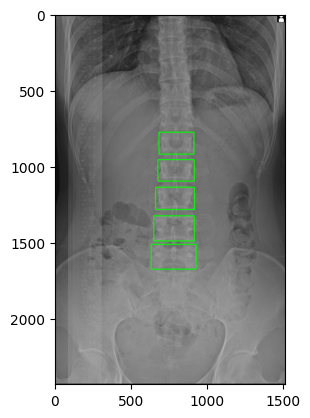

In [ ]:
# 첫 사진, 설명 경로
first_image_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_AP/DATA_AP/val/images/0063-F-036Y0.jpg"
first_bb_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_AP/DATA_AP/val/labels/0063-F-036Y0.txt"

# 이미지 불러오기
image = cv2.imread(first_image_path)
height, width, _ = image.shape

# 바운딩박스 그리기
with open(first_bb_path, "r") as f:
    lines = f.readlines()
for line in lines:
    parts = line.strip().split()
    class_id, x_center, y_center, box_w, box_h = map(float, parts)

    # YOLO 형식 → 픽셀 좌표 복원
    x_center *= width
    y_center *= height
    box_w *= width
    box_h *= height

    x1 = int(x_center - box_w / 2)
    y1 = int(y_center - box_h / 2)
    x2 = int(x_center + box_w / 2)
    y2 = int(y_center + box_h / 2)

    # 박스 그리기
    color = (0, 255, 0)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 5)

plt.imshow(image)
plt.show()